# pa005: High Value Customer Identification (Insiders)

## Solution Plan (IOT)

 ### 0.1. Input

1. Business problem
    - Select the most valuable costumers to join a loyalty program called "Insiders"
    

2. Data
    - Sales during the period of one year

 ### 0.2. Output

1. Refer some people elegible to be part of the loyalty program
            | client_id | is_insider | 
            | 20394     | yes(1)     |
            | 23948     | no (0)     |

 ### 0.3. Tasks

1. who are the people eligible for the loyalty program?
    - What does "being elegible" mean? Who are the "valuable customers"?
        - Invoicing:
            - High ATP
            - High LTV
            - Low recency
            - High basket size
            - Low probability of churn
        - Cost:
            - Low product return rate
        - Shopping Experience:       
            - High average rating
            
        
2. How many customers will be able to join the group?
    - Total number of customers
    - % Insiders Group
3. What are the main features of these customers?
        -  Age
        - Location
4. How much do the Insiders contribute to the total billing amount?
    - Total billing amout
    - % Insiders billing
5. Whet is the Insider's billing forecast for the coming months?
    - LTV Insiders group
    - Cohort analysis
6. What are the conditions to someone be elegible to the Insiders group?
    - The person has to be similar to the others in the group
8. How to ensure that the Insiders program is better tha the current model?
    - A/B test
    - Bayesian A/B test
    - Hypotesis test
9. What are the marketing plans for this group?
    - Discounts
    - Purchase preference
    - Free shipping

# 0.0. Imports

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns

import umap.umap_ as umap

from matplotlib import pyplot as plt
from plotly import express as px
from IPython.display import HTML

from dataprep.eda import create_report
from dataprep.connector import info_ui

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )


    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Dataset

In [3]:
# Load data
ecommerce = pd.read_csv('../data/Ecommerce.csv',encoding='latin1')

# Drop extra column
ecommerce = ecommerce.iloc[:,:-1]

# 1.0. Data description

In [4]:
ecommerce1 = ecommerce.copy()

## 1.1. Rename Columns

In [5]:
new_cols =  ['invoice_no', 'stock_code','description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
ecommerce1.columns = new_cols

## 1.2. Data Dimensions

In [6]:
ecommerce1.shape

(541909, 8)

## 1.3. Data types

In [7]:
ecommerce1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [8]:
ecommerce1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [9]:
# Missing values on customer ID
ecommerce_missing = ecommerce1[ecommerce1['customer_id'].isna()]
ecommerce_not_missing = ecommerce1[~ecommerce1['customer_id'].isna()]

In [10]:
ecommerce_missing_customerid = ecommerce_missing[['invoice_no','customer_id']].drop_duplicates()
ecommerce_missing_customerid['customer_id'] = np.arange( 19000, 19000 + len(ecommerce_missing_customerid), 1 )
ecommerce_missing = pd.merge(ecommerce_missing.drop('customer_id', axis = 1), ecommerce_missing_customerid, on = 'invoice_no', how = 'left')
ecommerce_missing = ecommerce_missing[ecommerce_not_missing.columns]
ecommerce1 = pd.concat([ecommerce_missing, ecommerce_not_missing])

In [11]:
# Drop description column
ecommerce1 = ecommerce1.drop('description', axis = 1)

In [12]:
ecommerce1.isna().sum()

invoice_no      0
stock_code      0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change Dtypes

In [13]:
# Invoice date
ecommerce1['invoice_date'] = pd.to_datetime(ecommerce1['invoice_date'], format = '%d-%b-%y')

# Customer id
ecommerce1['customer_id'] = ecommerce1['customer_id'].astype(np.int64)

In [14]:
ecommerce1.sort_values('invoice_no').head()

invoice_no stock_code  quantity invoice_date  unit_price  customer_id  \
0     536365     85123A         6   2016-11-29        2.55        17850   
6     536365      21730         6   2016-11-29        4.25        17850   
5     536365      22752         2   2016-11-29        7.65        17850   
1     536365      71053         6   2016-11-29        3.39        17850   
3     536365     84029G         6   2016-11-29        3.39        17850   

          country  
0  United Kingdom  
6  United Kingdom  
5  United Kingdom  
1  United Kingdom  
3  United Kingdom

## 1.7. Drop Duplicates

In [15]:
#ecommerce1 = ecommerce1.drop_duplicates()

## 1.8. Descriptive Statistics

In [16]:
num_attributes = ecommerce1.select_dtypes( include = ['int64', 'float64'])
cat_attributes = ecommerce1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.8.1. Numerical Attributes

In [17]:
# Central tendency (mean, median)
ct1 = ( num_attributes.apply( np.mean ) ).T
ct2 = ( num_attributes.apply( np.median ) ).T
# Dispersion ( std, min, max. range, skew, kurtosis)
d1 = ( num_attributes.apply( np.std ) ).T
d2 = ( num_attributes.apply( np.min ) ).T
d3 = ( num_attributes.apply( np.max ) ).T
d4 = ( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = ( num_attributes.apply( lambda x: x.max() - x.skew() ) ).T
d6 = ( num_attributes.apply( lambda x: x.max() - x.kurtosis() ) ).T

# Concatenate
ecommerce_stats = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6], axis = 1 ).reset_index()
ecommerce_stats.columns = ['attributes','min','max', 'range', 'mean', 'median',' std',' skew', 'kurtosis']
ecommerce_stats

attributes       min      max      range          mean    median  \
0     quantity -80995.00  80995.0  161990.00      9.552250      3.00   
1   unit_price -11062.06  38970.0   50032.06      4.611114      2.08   
2  customer_id  12346.00  22709.0   10363.00  16688.840453  16249.00   

           std          skew      kurtosis  
0   218.080957  80995.264076 -38774.160031  
1    96.759764  38783.493028 -20035.719097  
2  2911.408666  22708.512551  22709.804287

#### 1.8.1.1. Numerical attributes - Investigating

In [18]:
# Negative values for quantity
# Negative values for unit price

### 1.8.2. Categorical Attributes

##### Invoice Number

In [19]:
 # Invoice number
invoices_w_letters = ecommerce1.loc[ecommerce1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), : ]
negative_quantity = len( invoices_w_letters.loc[invoices_w_letters['quantity'] < 0, : ] )
print('Total number of invoices number with letter: ',len( invoices_w_letters ), '\nTotal number of negative quantity: ', negative_quantity)

Total number of invoices number with letter:  9291 
Total number of negative quantity:  9288


##### Stock code

In [20]:
# Stock code
# Check only characters on stock code
ecommerce1.loc[ecommerce1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$',  x ) ) ), 'stock_code' ].unique()

# Action: Remove stock code in ['DOT', 'M', 'S', 'AMAZONFEE', 'm', 'POST', 'DCGSSBOY', 'DCGSSGIRL', 'B', 'D', 'PADS', 'CRUK']


array(['DOT', 'M', 'S', 'AMAZONFEE', 'm', 'POST', 'DCGSSBOY', 'DCGSSGIRL',
       'B', 'D', 'PADS', 'CRUK'], dtype=object)

##### Description

In [21]:
# Action: delete description

##### Country

In [22]:
ecommerce1['country'].unique()

array(['United Kingdom', 'EIRE', 'Bahrain', 'Israel', 'Hong Kong',
       'Unspecified', 'France', 'Switzerland', 'Portugal', 'Australia',
       'Netherlands', 'Germany', 'Norway', 'Spain', 'Poland', 'Italy',
       'Belgium', 'Lithuania', 'Japan', 'Iceland', 'Channel Islands',
       'Denmark', 'Cyprus', 'Sweden', 'Austria', 'Finland', 'Greece',
       'Singapore', 'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Brazil', 'USA', 'European Community',
       'Malta', 'RSA'], dtype=object)

In [23]:
ecommerce1['country'].value_counts(normalize = True)#.head(4)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [24]:
ecommerce1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by = 'customer_id', ascending = False).head(4)

country  customer_id
36  United Kingdom         7587
14         Germany           95
13          France           90
10            EIRE           44

# 2.0. Data Filtering

In [25]:
ecommerce2 = ecommerce1

In [26]:
# Categorical attributes

# Stock code
ecommerce2 = ecommerce2[~ecommerce2['stock_code'].isin(['DOT', 'M', 'S', 'AMAZONFEE', 'm', 'POST', 'DCGSSBOY', 'DCGSSGIRL', 'B', 'D', 'PADS', 'CRUK'])]

# Country
ecommerce2 = ecommerce2[~ecommerce2['country'].isin( ['European Community', 'Unspecified'] )] 

# Numerical attributes

# Unit price
ecommerce2 = ecommerce2[ecommerce2['unit_price'] >= 0.04]

# Bad users
ecommerce2 = ecommerce2[~ecommerce2['customer_id'].isin( [16446] )]

# Quantity
ecommerce_returns = ecommerce2.loc[ecommerce2['quantity'] < 0, : ] 
ecommerce_purchases = ecommerce2.loc[ecommerce2['quantity'] >= 0, : ] 

# 3.0. Feature Engineering

In [27]:
ecommerce3 = ecommerce2

In [28]:
customer_df = ecommerce3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index = True)

## 3.1. Feature Creation

### 3.1.1. Gross Revenue

In [29]:
# Gross Revenue
ecommerce_purchases['gross_revenue'] = ecommerce_purchases['quantity'] * ecommerce_purchases['unit_price']
df_gross_revenue = ecommerce_purchases[['gross_revenue','customer_id']].groupby('customer_id').sum().reset_index()
customer_df = pd.merge(customer_df, df_gross_revenue,on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency

In [30]:
# Recency - Last day purchase
df_recency = ecommerce_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency'] = (ecommerce_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency']].copy()

# Merge
customer_df = pd.merge(customer_df, df_recency, on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id       0
gross_revenue    91
recency          91
dtype: int64

### 3.1.3. Quantity of purchases

In [31]:
# qtty purchased
df_frequency = ecommerce_purchases[['invoice_no', 'customer_id']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns = {'invoice_no' : 'qtty_invoices'})

# Merge
customer_df = pd.merge(customer_df, df_frequency, on = 'customer_id', how = 'left')
customer_df.isna().sum()

customer_id       0
gross_revenue    91
recency          91
qtty_invoices    91
dtype: int64

### 3.1.4. Quantity of items purchased

In [32]:
# qtty purchased
df_products = ecommerce_purchases[['quantity', 'customer_id']].groupby('customer_id').sum().reset_index().rename(columns = {'quantity' : 'qtty_items'})

# Merge
customer_df = pd.merge(customer_df, df_products, on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id       0
gross_revenue    91
recency          91
qtty_invoices    91
qtty_items       91
dtype: int64

### 3.1.5. Quantity of products purchased

In [33]:
# qtty purchased
df_products = ecommerce_purchases[['stock_code', 'customer_id']].groupby('customer_id').count().reset_index().rename(columns = {'stock_code' : 'qtty_products'})

# Merge
customer_df = pd.merge(customer_df, df_products, on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id       0
gross_revenue    91
recency          91
qtty_invoices    91
qtty_items       91
qtty_products    91
dtype: int64

### 3.1.6. Average Ticket

In [34]:
# AVG Ticket
df_avgticket = ecommerce_purchases[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns = {'gross_revenue':'avg_ticket'})

# Merge
customer_df = pd.merge(customer_df, df_avgticket, on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id       0
gross_revenue    91
recency          91
qtty_invoices    91
qtty_items       91
qtty_products    91
avg_ticket       91
dtype: int64

### 3.1.7. Average Recency Days

In [35]:
# AVG Recency days
aux_recency = ecommerce2[['customer_id','invoice_date']].drop_duplicates().sort_values( ['customer_id','invoice_date'], ascending = [True, True])
aux_recency['next_customer_id'] = aux_recency['customer_id'].shift()
aux_recency['previous_date'] = aux_recency['invoice_date'].shift()
aux_recency['avg_recency_days'] = aux_recency.apply( lambda x:( ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan), axis = 1 )
aux_recency = aux_recency.drop( ['invoice_date','next_customer_id','previous_date'], axis = 1).dropna()
aux_recency = aux_recency.groupby('customer_id').mean().reset_index()

# Merge
customer_df = pd.merge(customer_df, aux_recency, on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id            0
gross_revenue         91
recency               91
qtty_invoices         91
qtty_items            91
qtty_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.8. Fequecy Purchase

In [36]:
# Frquency purchase
frequency_df = (
                ecommerce2[['customer_id','invoice_no', 'invoice_date']].drop_duplicates()
                                                                        .groupby('customer_id')
                                                                        .agg( max_date = ('invoice_date', 'max'),
                                                                              min_date = ('invoice_date', 'min'),
                                                                              qtty_purchases = ('invoice_no', 'count')     
                                                                            ).reset_index()
              )
frequency_df['date_interval'] = ((frequency_df['max_date'] - frequency_df['min_date']).dt.days)
frequency_df['frequency'] = frequency_df.apply(lambda x: ( x['qtty_purchases'] / x['date_interval'] ) if x['date_interval'] != 0 else 0, axis = 1 )

# Merge
customer_df = pd.merge(customer_df, frequency_df[['customer_id','frequency']], on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id            0
gross_revenue         91
recency               91
qtty_invoices         91
qtty_items            91
qtty_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
dtype: int64

### 3.1.9. Returns

In [37]:
# Number of returns
customer_returns = ecommerce_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns = {'quantity' : 'qtty_returns'})
customer_returns['qtty_returns'] = customer_returns['qtty_returns'] * - 1

# Merge
customer_df = pd.merge(customer_df, customer_returns, on = 'customer_id', how = 'left')
customer_df.loc[customer_df['qtty_returns'].isna(),'qtty_returns'] = 0

customer_df.isna().sum()

customer_id            0
gross_revenue         91
recency               91
qtty_invoices         91
qtty_items            91
qtty_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
qtty_returns           0
dtype: int64

### 3.1.10. Basket Size

In [38]:
basket_size = (ecommerce_purchases[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                 .agg(invoices = ('invoice_no','nunique'),
                                                                      products = ('quantity','sum')).reset_index() 
                
)

basket_size['basket_size'] = basket_size['products'] / basket_size['invoices']

# Merge
customer_df = pd.merge(customer_df, basket_size[['customer_id','basket_size']], on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id            0
gross_revenue         91
recency               91
qtty_invoices         91
qtty_items            91
qtty_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
qtty_returns           0
basket_size           91
dtype: int64

### 3.1.11. Unique Basket Size

In [39]:
avg_basket_size = ( ecommerce_purchases[['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                 .agg( invoices = ('invoice_no','nunique'),
                                                                       products = ('stock_code','nunique') ).reset_index() 
                
                  )

avg_basket_size['unique_basket_size'] = avg_basket_size['products'] / avg_basket_size['invoices']

# Merge
customer_df = pd.merge(customer_df, avg_basket_size[['customer_id','unique_basket_size']], on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id              0
gross_revenue           91
recency                 91
qtty_invoices           91
qtty_items              91
qtty_products           91
avg_ticket              91
avg_recency_days      2816
frequency                0
qtty_returns             0
basket_size             91
unique_basket_size      91
dtype: int64

# 4.0. Exploratory Data Analysis

In [40]:
ecommerce4 = customer_df.dropna().copy()

## 4.1. Univariate Analysis

Metrics: min, max, range, dispertion

         men, median 
         
         std, variance
         
         coefficient of variation (cv)
         
         distribution
         
Conclusions:

Gross Revenue - ok

Recency - ok

Qtty invoices - ok

Qtty intems

Qtty products


  0%|                                                  | 0/2423 [00:00<?, ?it/s]


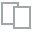
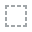
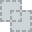
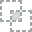
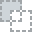
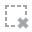
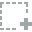
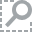
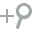
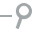
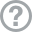
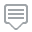
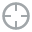
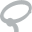
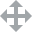
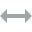
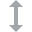
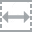
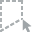
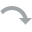
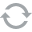
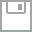
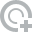
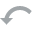
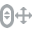
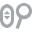
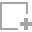
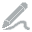
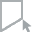
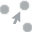
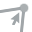
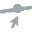

In [41]:
report = create_report(ecommerce4).show()

### 4.1.1. Gross Revenue

In [42]:
ecommerce4.sort_values('gross_revenue', ascending = False).head(5)

customer_id  gross_revenue  recency  qtty_invoices  qtty_items  \
2338        14646      279138.02      1.0           72.0    196844.0   
1879        18102      259657.30      0.0           60.0     64124.0   
1831        17450      194550.79      8.0           46.0     69993.0   
1496        14911      140450.72      1.0          199.0     80263.0   
2409        12415      124564.53     24.0           20.0     77373.0   

      qtty_products  avg_ticket  avg_recency_days  frequency  qtty_returns  \
2338         2060.0  135.503893          7.844444   0.206799         288.0   
1879          431.0  602.453132         14.680000   0.163488           0.0   
1831          337.0  577.302047         12.821429   0.136490         952.0   
1496         5673.0   24.757751          2.601399   0.653226        3332.0   
2409          713.0  174.704811         20.866667   0.076677         427.0   

      basket_size  unique_basket_size  
2338  2733.944444            9.708333  
1879  1068.733333            2.500000  
1831  1521.586957            2.695652  
1496   403.331658            8.974874  
2409  3868.650000           22.150000

### 4.1.2. Qtty Products

In [43]:
ecommerce4[ecommerce4['qtty_products'] == 7667]

Empty DataFrame
Columns: [customer_id, gross_revenue, recency, qtty_invoices, qtty_items, qtty_products, avg_ticket, avg_recency_days, frequency, qtty_returns, basket_size, unique_basket_size]
Index: []

### 4.1.3. AVG Ticket

In [44]:
ecommerce4.sort_values('avg_ticket', ascending = False).head(5)

customer_id  gross_revenue  recency  qtty_invoices  qtty_items  \
2505        15749       44534.30    235.0            3.0     18028.0   
2942        18087        3202.92    290.0            1.0      3906.0   
2399        16532        6748.80     17.0            3.0      2016.0   
1982        12755        3811.95    280.0            2.0      1491.0   
4368        12798        6977.04     10.0            3.0      5256.0   

      qtty_products  avg_ticket  avg_recency_days  frequency  qtty_returns  \
2505           10.0   4453.4300              97.0   0.041237        9014.0   
2942            1.0   3202.9200              78.5   0.019108         336.0   
2399            4.0   1687.2000             160.5   0.009346           0.0   
1982            4.0    952.9875              58.0   0.025862         624.0   
4368            8.0    872.1300              80.0   0.018750           0.0   

      basket_size  unique_basket_size  
2505  6009.333333            1.666667  
2942  3906.000000            1.000000  
2399   672.000000            0.666667  
1982   745.500000            2.000000  
4368  1752.000000            2.000000

In [80]:
ecommerce[ecommerce['CustomerID'] == 16446] # Action: remove this customer

InvoiceNo StockCode                  Description  Quantity InvoiceDate  \
194354    553573     22980       PANTRY SCRUBBING BRUSH         1   16-May-17   
194355    553573     22982          PANTRY PASTRY BRUSH         1   16-May-17   
540421    581483     23843  PAPER CRAFT , LITTLE BIRDIE     80995    7-Dec-17   
540422   C581484     23843  PAPER CRAFT , LITTLE BIRDIE    -80995    7-Dec-17   

        UnitPrice  CustomerID         Country  
194354       1.65     16446.0  United Kingdom  
194355       1.25     16446.0  United Kingdom  
540421       2.08     16446.0  United Kingdom  
540422       2.08     16446.0  United Kingdom

### 4.1.4. Frequency

In [82]:
ecommerce4[ecommerce4['frequency'] > 3]

customer_id  gross_revenue  recency  qtty_invoices  qtty_items  \
5663        18139        8438.34     17.0            6.0      5557.0   
5743        15060         301.84      8.0            4.0       262.0   

      qtty_products  avg_ticket  avg_recency_days  frequency  qtty_returns  \
5663          159.0   53.071321               1.0        6.0           0.0   
5743          120.0    2.515333               1.0        4.0           0.0   

      basket_size  unique_basket_size  
5663   926.166667            5.833333  
5743    65.500000           20.000000

### 4.1.5. AVG Basket Size

In [84]:
ecommerce4[ecommerce4['basket_size'] > 4000]

customer_id  gross_revenue  recency  qtty_invoices  qtty_items  \
2505        15749       44534.30    235.0            3.0     18028.0   
4036        12590        9341.26    211.0            1.0      4282.0   

      qtty_products   avg_ticket  avg_recency_days  frequency  qtty_returns  \
2505           10.0  4453.430000              97.0   0.041237        9014.0   
4036           67.0   139.421791              21.0   0.095238           4.0   

      basket_size  unique_basket_size  
2505  6009.333333            1.666667  
4036  4282.000000           67.000000

In [99]:
ecommerce3[ecommerce3['customer_id'].isin([15749,12590])].head(15)

9014

## 4.2. Bivariate Analysis

<Figure size 2500x1200 with 0 Axes>

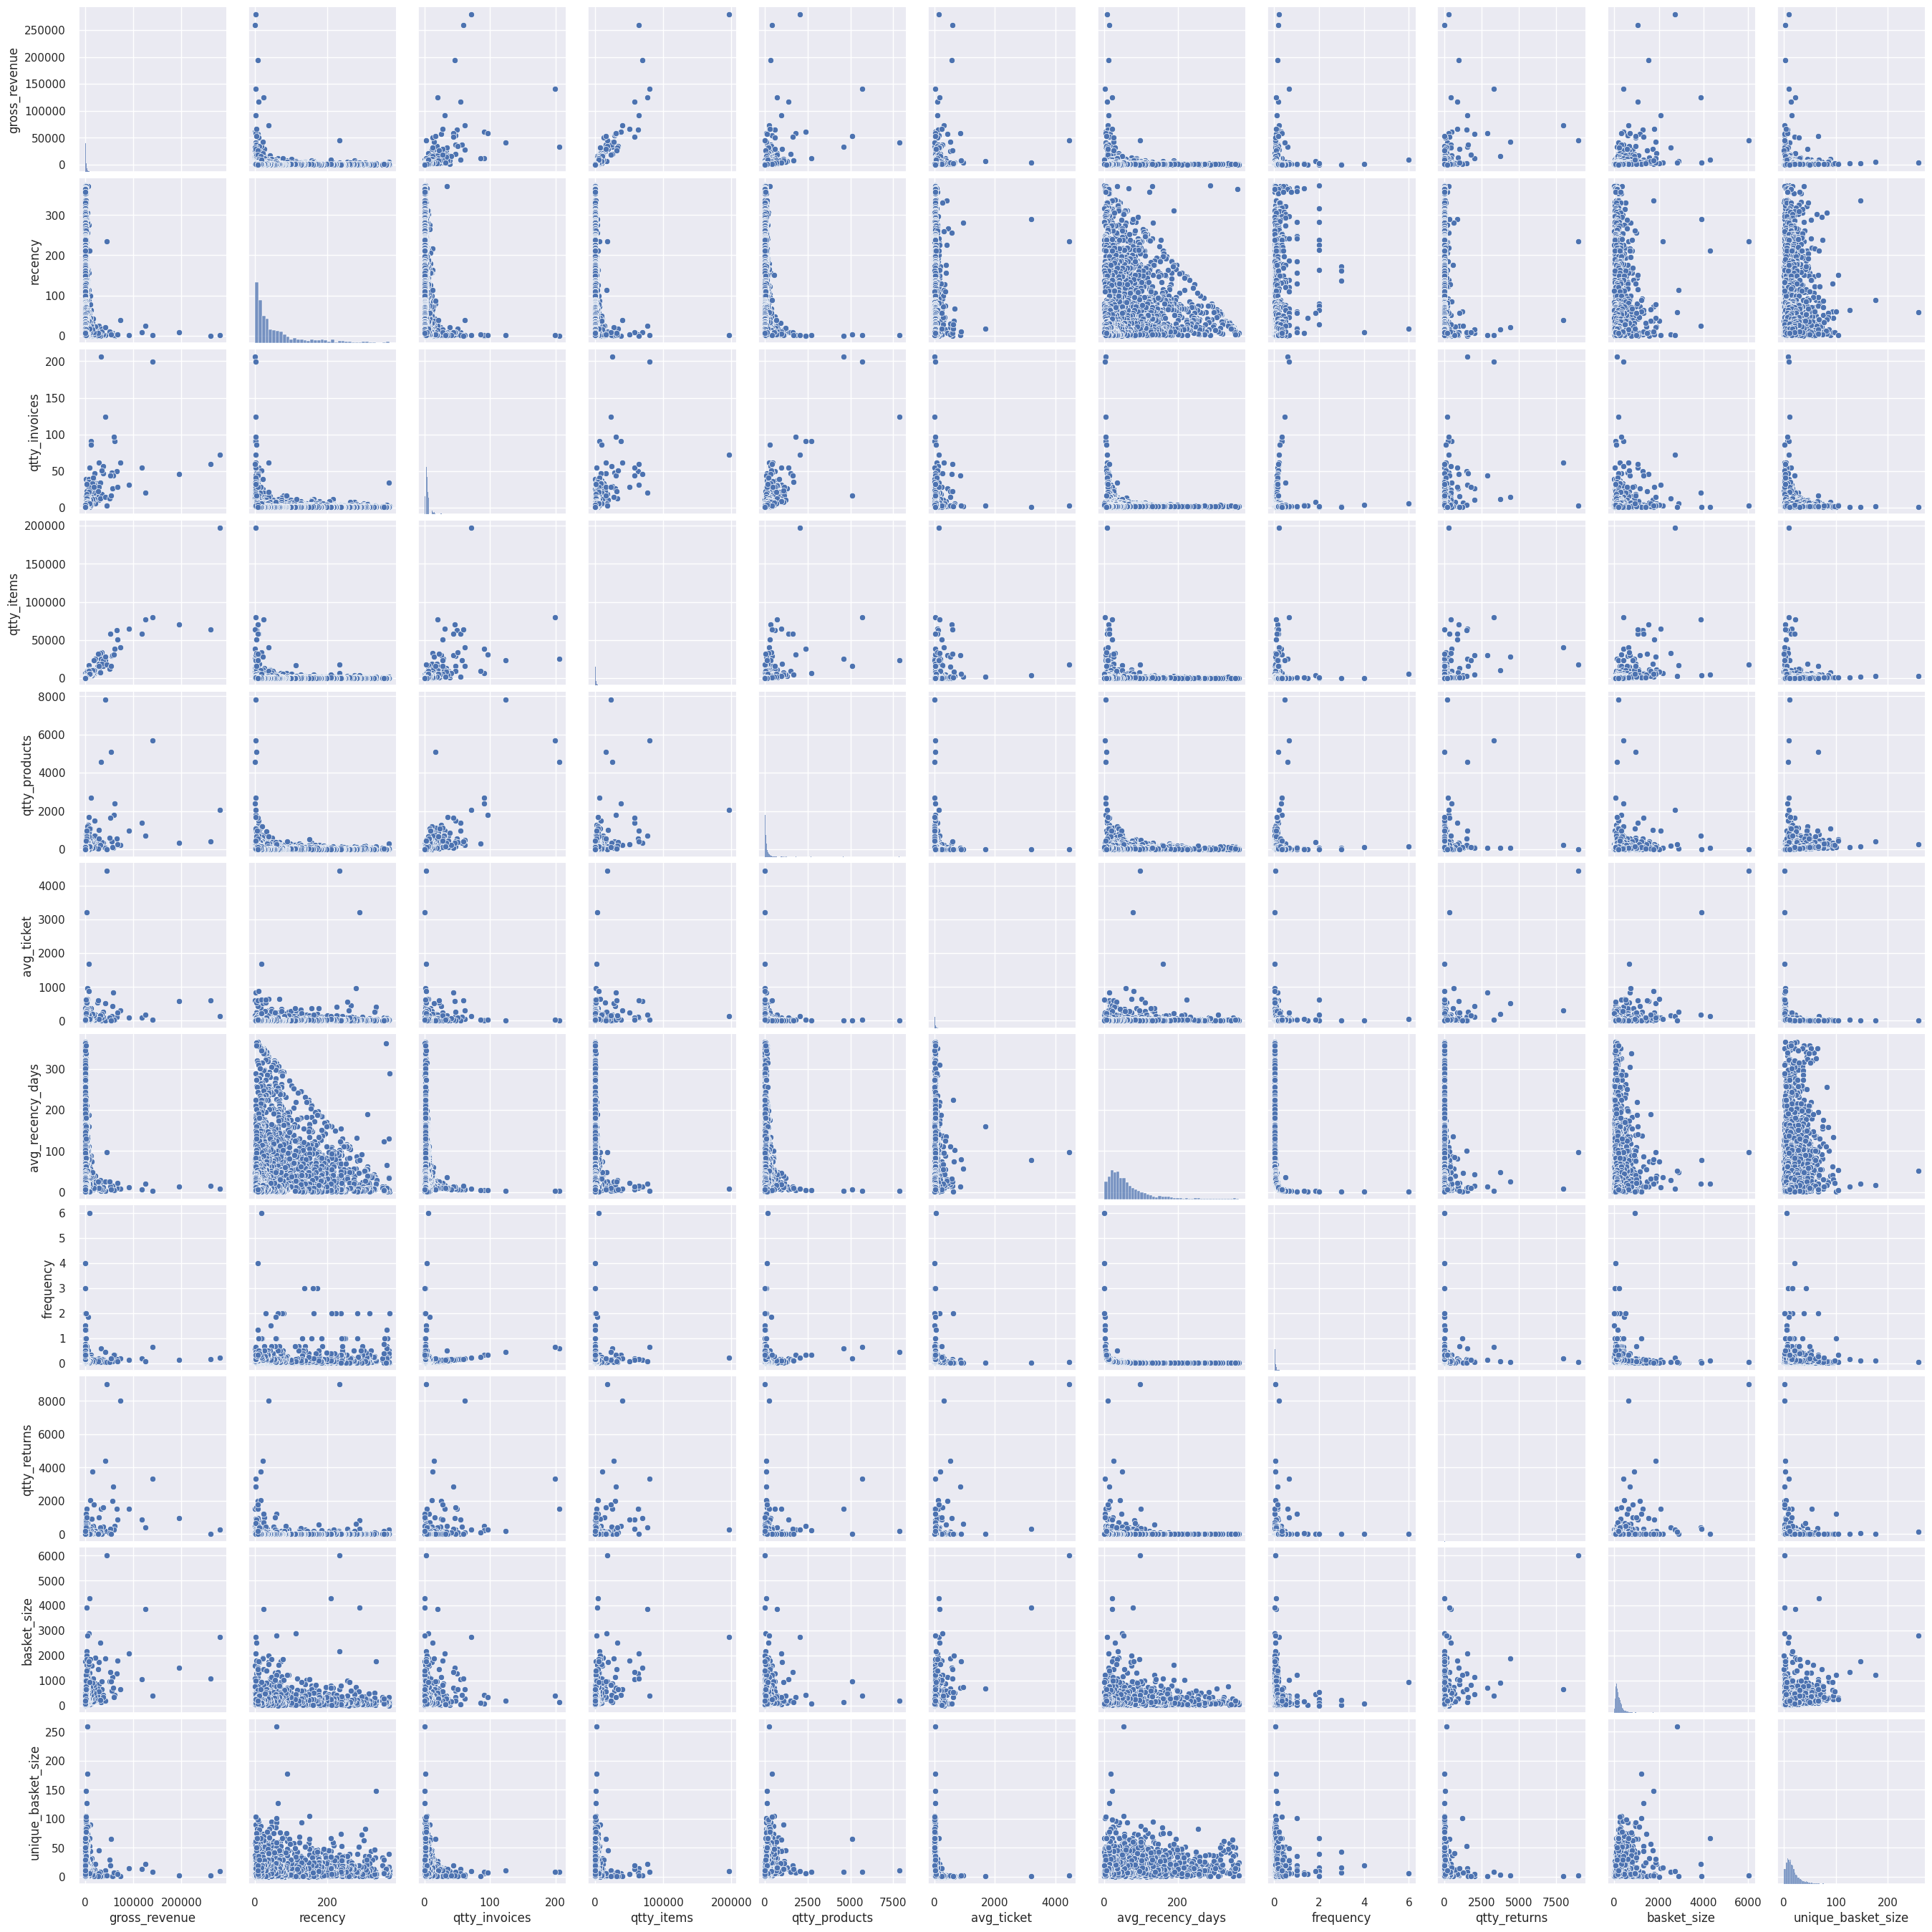

In [46]:
ecommerce_pairplot = ecommerce4.drop('customer_id', axis = 1)
plt.figure( figsize = ( 25, 12 ))
sns.pairplot( ecommerce_pairplot )

- Frequency has low variance
- AVG Ticket has low variance

## 4.3. Space Study

In [47]:
ecommerce4_3 = ecommerce4.drop(columns = ['customer_id'], axis = 1).copy()

In [48]:
mm = pp.MinMaxScaler()
cols = ecommerce4_3.columns
for col in cols:
    ecommerce4_3[col] = mm.fit_transform(ecommerce4_3[[col]])
X = ecommerce4_3.copy()

### 4.3.1. PCA

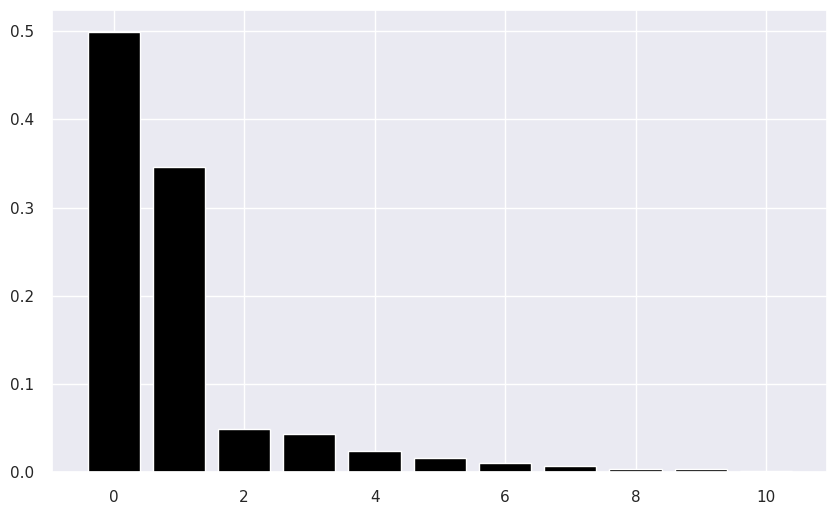

In [49]:
pca = dd.PCA( n_components = X.shape[1] )
principal_components = pca.fit_transform( X )

# Prot explained variable
features = range(pca.n_components_)

plt.figure( figsize = ( 10, 6 ))
plt.bar(features, pca.explained_variance_ratio_, color = 'black')

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot: xlabel='0', ylabel='1'>

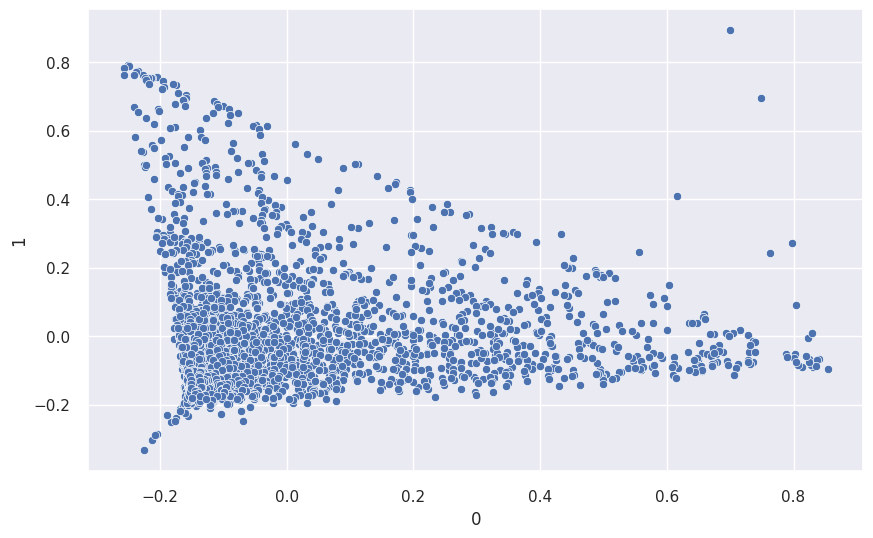

In [50]:
plt.figure( figsize = ( 10, 6 ))
sns.scatterplot( x = 0, y = 1, data = df_pca )

### 4.3.2. UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

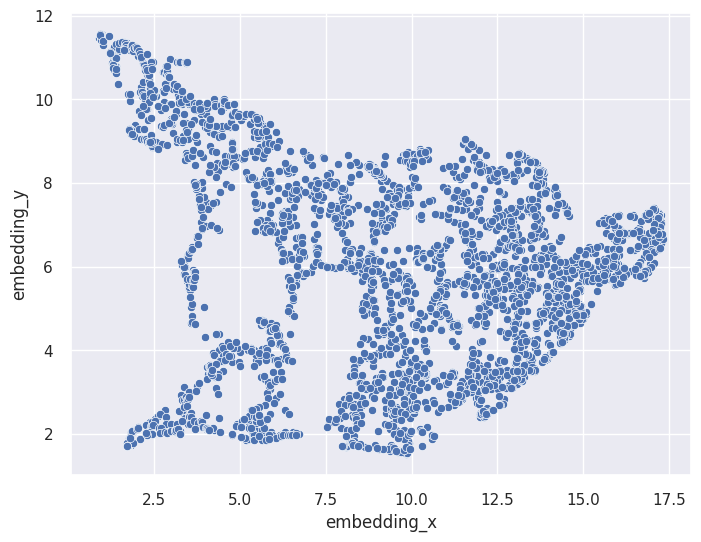

In [51]:
reducer = umap.UMAP( random_state = 42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[: , 0]
df_pca['embedding_y'] = embedding[: , 1]

# Plot UMAP
plt.figure(figsize=(8, 6))
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',
                 data = df_pca )

### 4.3.3. t-SNE

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

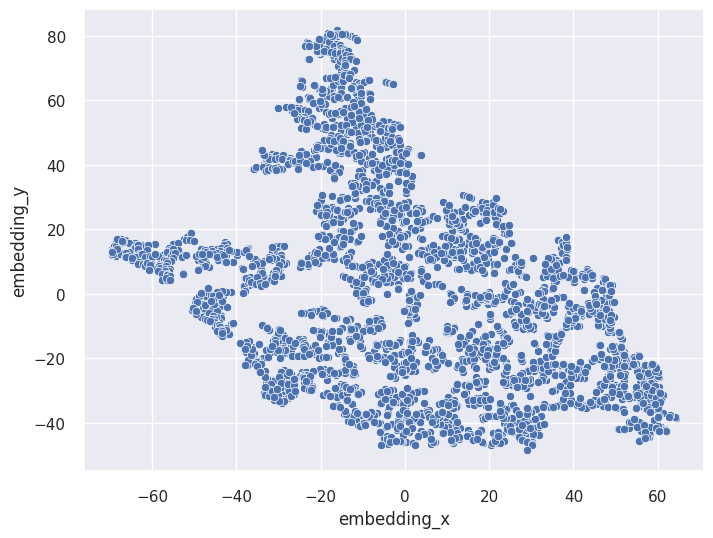

In [52]:
reducer = TSNE( n_components = 2, random_state = 42, n_jobs = -1 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[: , 0]
df_pca['embedding_y'] = embedding[: , 1]

# Plot UMAP
plt.figure(figsize=(8, 6))
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',
                 data = df_pca )

### 4.3.4. Tree-Based Embedding

In [53]:
y = X['gross_revenue']
X = X.drop('gross_revenue', axis = 1)

In [54]:
# Model definition
rf_model = RandomForestRegressor( n_estimators = 100, random_state = 42 )

# Model training
rf_model.fit( X, y )

# Leaf
df_leaf = pd.DataFrame( rf_model.apply( X ) )

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

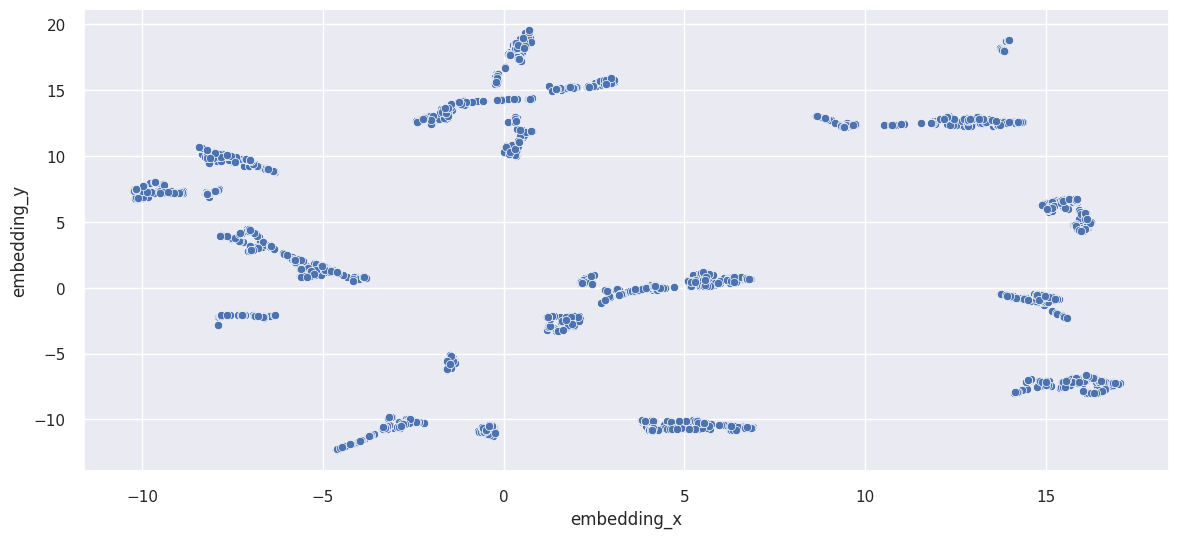

In [55]:
reducer = umap.UMAP( random_state = 42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_leaf['embedding_x'] = embedding[: , 0]
df_leaf['embedding_y'] = embedding[: , 1]

# Plot UMAP
plt.figure(figsize=(14, 6))
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',
                 data = df_leaf )

# 5.0. Data Preparation

In [56]:
ecommerce5 = ecommerce4.copy()

## 5.1. Normalization

## 5.1. Rescaling

In [100]:
ecommerce5.columns

Index(['customer_id', 'gross_revenue', 'recency', 'qtty_invoices',
       'qtty_items', 'qtty_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qtty_returns', 'basket_size', 'unique_basket_size'],
      dtype='object')

In [101]:
# Minmax Scaler
ss = pp.MinMaxScaler()
ecommerce5['gross_revenue'] = ss.fit_transform(ecommerce5[['gross_revenue']])
ecommerce5['recency'] = ss.fit_transform(ecommerce5[['recency']])
ecommerce5['qtty_invoices'] = ss.fit_transform(ecommerce5[['qtty_invoices']])
ecommerce5['qtty_items'] = ss.fit_transform(ecommerce5[['qtty_items']])
ecommerce5['qtty_products'] = ss.fit_transform(ecommerce5[['qtty_products']])
ecommerce5['avg_ticket'] = ss.fit_transform(ecommerce5[['avg_ticket']])
ecommerce5['avg_recency_days'] = ss.fit_transform(ecommerce5[['avg_recency_days']])
ecommerce5['frequency'] = ss.fit_transform(ecommerce5[['frequency']])
ecommerce5['qtty_returns'] = ss.fit_transform(ecommerce5[['qtty_returns']])
ecommerce5['basket_size'] = ss.fit_transform(ecommerce5[['basket_size']])
ecommerce5['unique_basket_size'] = ss.fit_transform(ecommerce5[['unique_basket_size']])

## 5.1. Transformation

# 6.0. Feature Selection

In [102]:
ecommerce6 = ecommerce5.copy()

# 7.0. Hyperparameter Fine-Tunning

In [103]:
ecommerce7 = ecommerce6.copy()
X = ecommerce7.drop('customer_id', axis = 1).copy()

In [104]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluster Sum of Square (WSS)

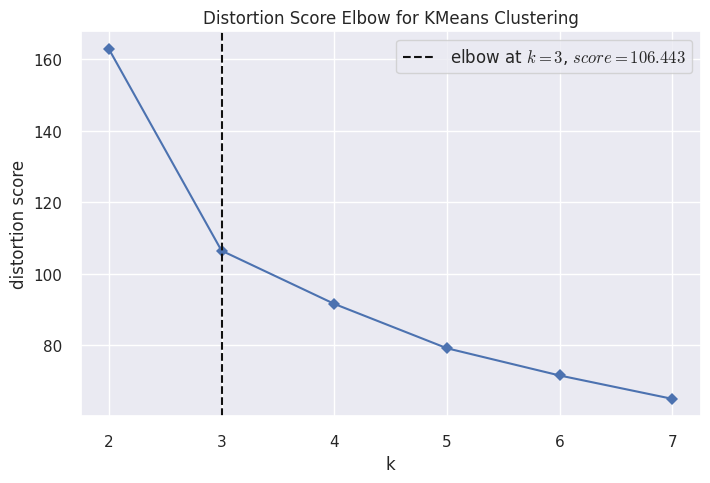

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [105]:
kmeans = KElbowVisualizer( c.KMeans(), k = clusters, timings = False)
plt.figure(figsize=(8, 5))
kmeans.fit( X )
kmeans.show()

## 7.2. Sillhouette Score

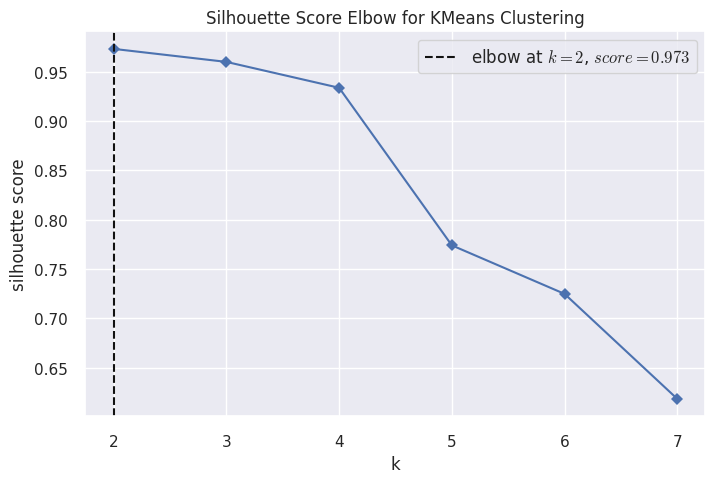

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [65]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KElbowVisualizer( c.KMeans(), k = clusters, metric = 'silhouette', timings = False)
plt.figure(figsize=(8, 5))
kmeans.fit( X )
kmeans.show()

### 7.2.1. Silhouette Analysis

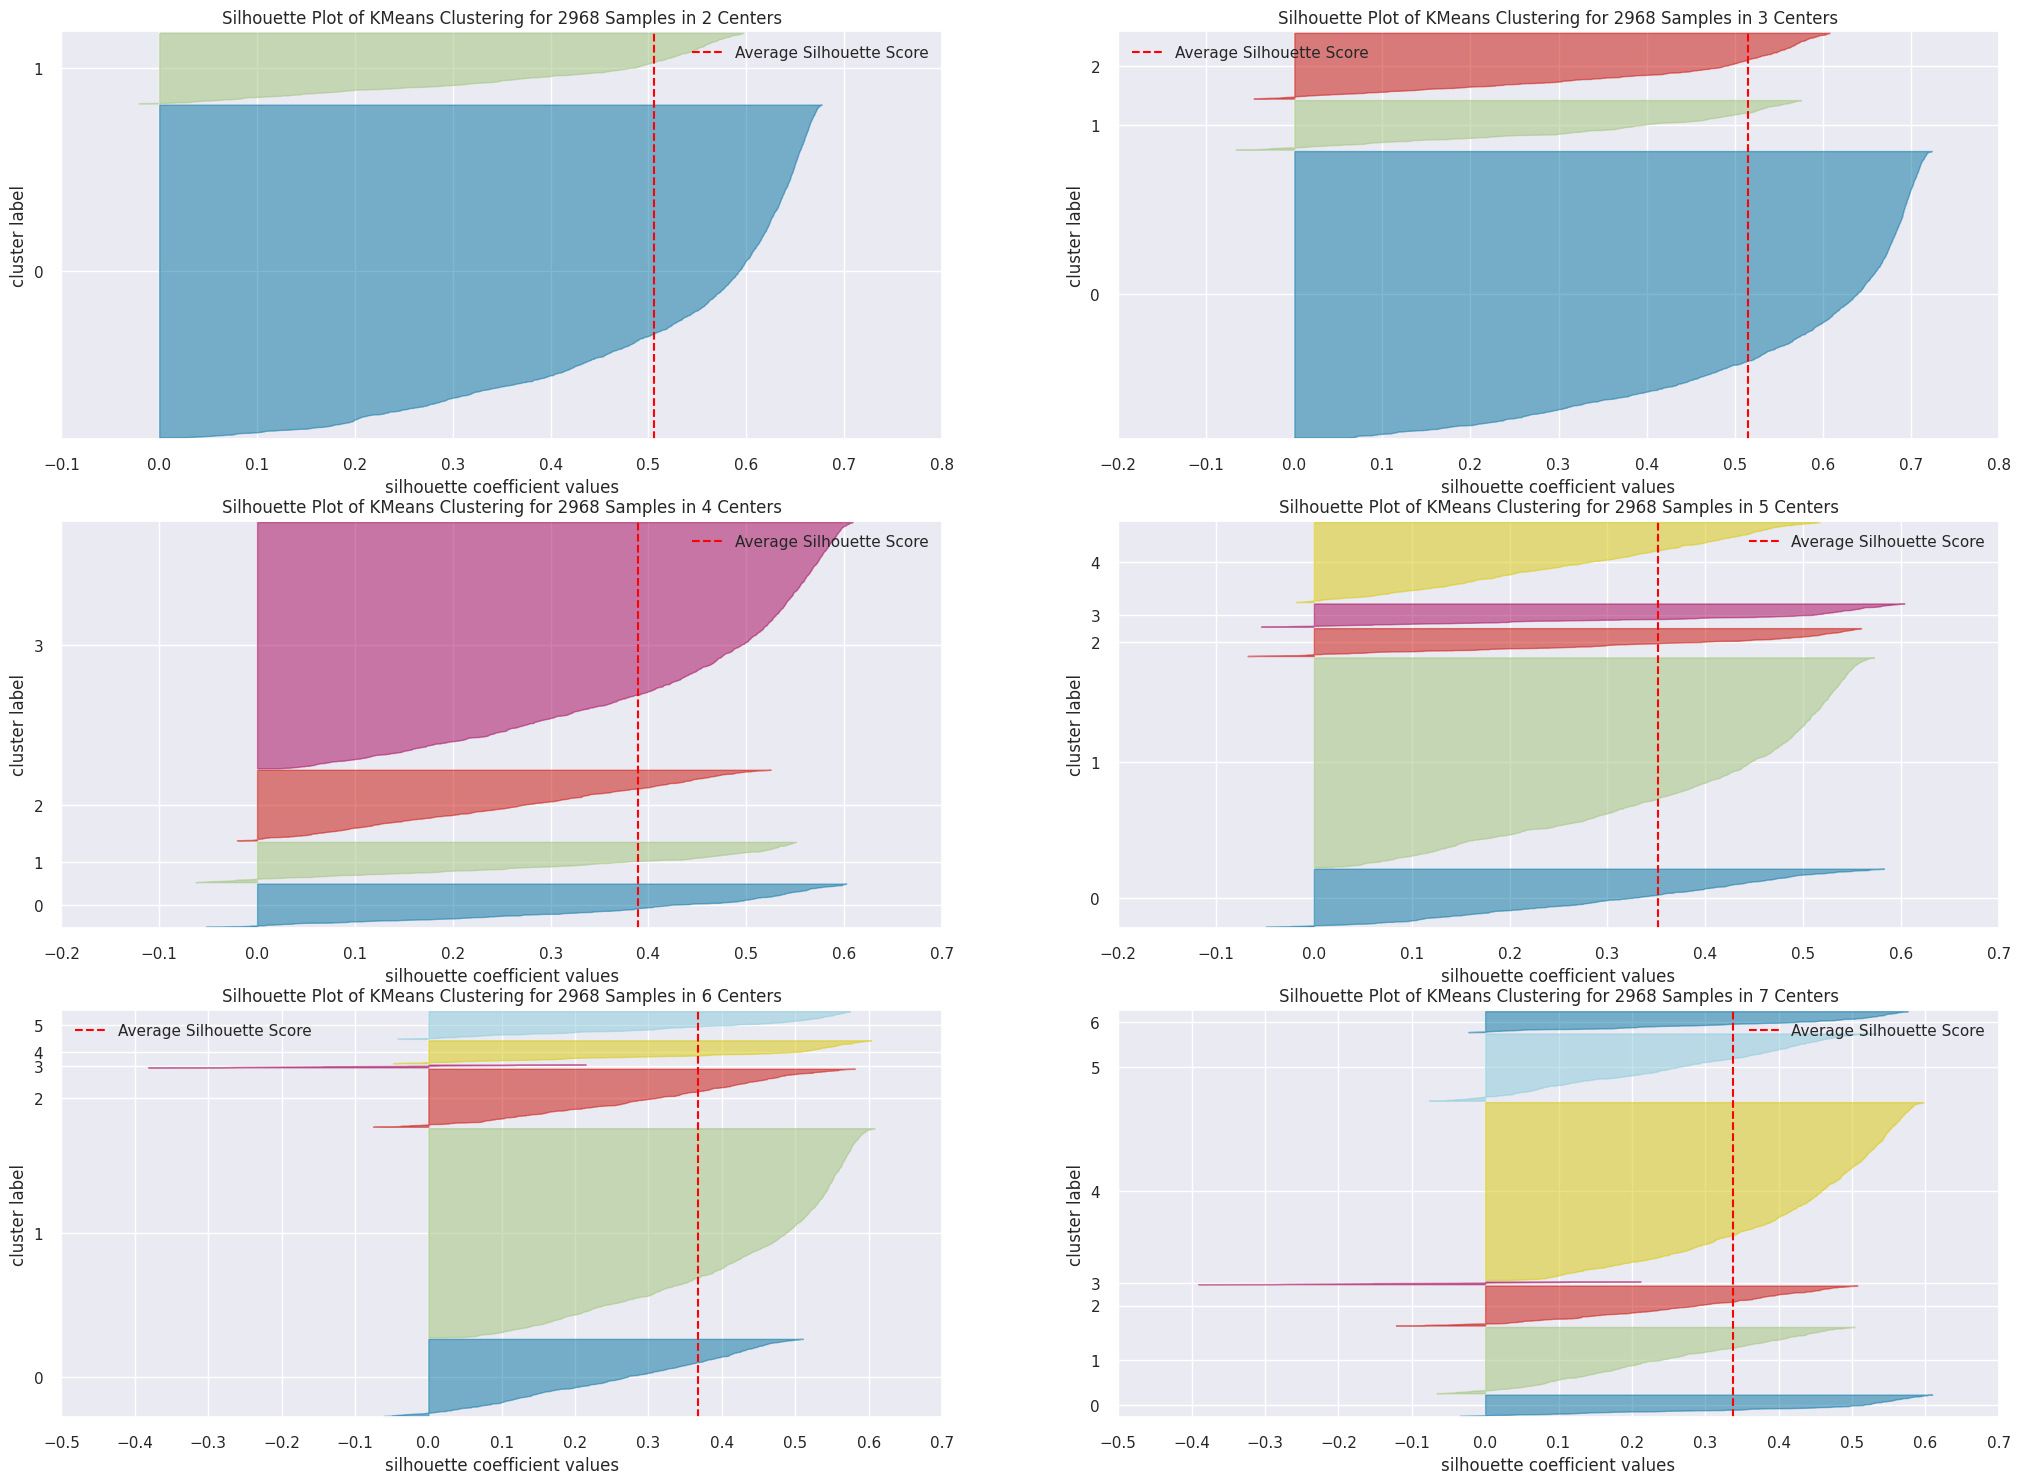

In [106]:
fig, ax = plt.subplots( 3, 2, figsize=(25,18) )
for k in clusters:
    km = c.KMeans(n_clusters = k, init = 'random', n_init = 10, max_iter = 100, random_state = 42)
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors = 'yellowbrick', ax = ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# 8.0. Model Training

## 8.1. K-Means

In [67]:
# Model definition
k = 3
kmeans = c.KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)
# Model training
kmeans.fit( X )

# Clustering
labels = kmeans.predict( X )## 8.1. K-Means

## 8.2. Cluster Validation

In [68]:
## WSS (Within-cluster sum of square)
print("WSS value: {}".format( kmeans.inertia_))

## SS ( Silhouette Score)
print("SS value: {}".format ( m.silhouette_score(X, labels, metric = 'euclidean' ) ) )

WSS value: 24367639466.587715
SS value: 0.9373785030671331


# 9.0. Cluster Analysis

In [69]:
ecommerce9 = ecommerce6.copy()
ecommerce9['cluster'] = labels

## 9.1. Visual Inspection

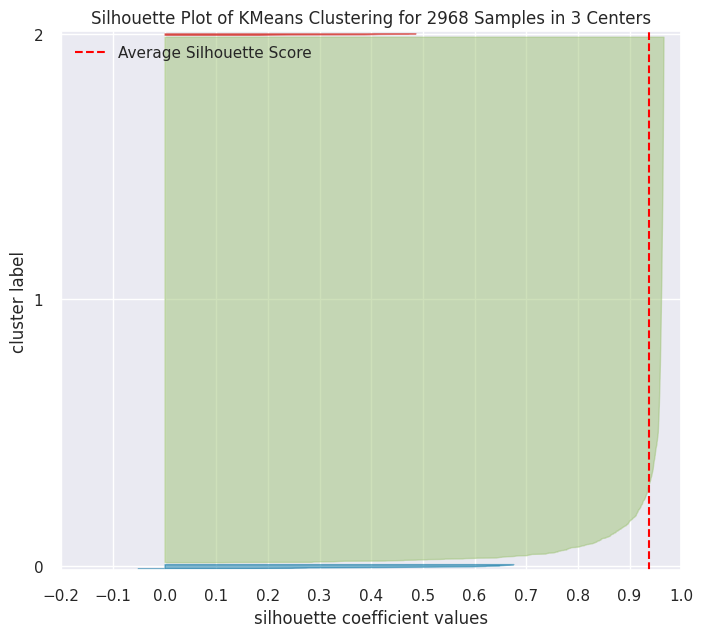

In [70]:
plt.figure(figsize=(8, 7))
visualizer = SilhouetteVisualizer (kmeans, colors = 'yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## 9.2. 2d plot

In [ ]:
df_viz = ecommerce9.drop(columns = 'customer_id', axis = 1)
sns.pairplot(df_viz, hue = 'cluster', palette = "dark:salmon_r")

## 9.3. UMAP

In [ ]:
reducer = umap.UMAP( n_neighbors = 20, random_state = 42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[: , 0]
df_viz['embedding_y'] = embedding[: , 1]

# Plot UMAP
plt.figure(figsize=(8, 7))
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',
                 hue = 'cluster',
                 palette = sns.color_palette('hls', n_colors = len( df_viz['cluster'].unique() ) ), 
                 data = df_viz )

In [ ]:
#fig = px.scatter_3d(ecommerce9, x='recency',y='invoice_no', z= 'gross_revenue', color = 'cluster' )
#fig.show()

## 9.2. Cluster Profile

In [71]:
# Number of customers
no_customers = ecommerce9[['customer_id','cluster']].groupby('cluster').count().reset_index()
no_customers['percentage'] = ( no_customers['customer_id'] /  no_customers['customer_id'].sum() ) * 100

# AVG Gross Revenue
class_gross_revenue = ecommerce9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index().rename(columns = {'gross_revenue':'avg_gross_revenue'})
df_cluster = pd.merge(no_customers, class_gross_revenue, how = 'inner', on = 'cluster')

# AVG Recency days
class_recency = ecommerce9[['recency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, class_recency, how = 'inner', on = 'cluster')

# AVG invoices
class_invoices = ecommerce9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, class_invoices, how = 'inner', on = 'cluster')

# AVG ticket
class_avgticket = ecommerce9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, class_avgticket, how = 'inner', on = 'cluster')

# Percentual Gross Revenue
perc_gross_revenue = ecommerce9[['gross_revenue','cluster']].groupby('cluster').sum().reset_index()
perc_gross_revenue['percentual_gross_revenue'] = ( perc_gross_revenue['gross_revenue'] /  perc_gross_revenue['gross_revenue'].sum() ) * 100
df_cluster = pd.merge(df_cluster, perc_gross_revenue, how = 'inner', on = 'cluster')

KeyError: "['invoice_no'] not in index"

In [ ]:
df_cluster

### Cluster 01: (Insider Candidades)
    - Customers: 6 (0.14% of the customers)
    - AVG Recency: 7 days
    - AVG invoices: 89
    - AVG Revenue: $ 182.108.000
    
### Cluster 02:
    - Customers: 31 (0.71% of the customers)
    - AVG Recency: 14 days
    - AVG invoices: 53
    - AVG Revenue: $ 40.543,52
    
### Cluster 03: 
    - Customers: 4335 (99% of the customers)
    - AVG Recency: 92 days
    - AVG invoices: 5
    - AVG Revenue: $ 1.372,57

# 10.0. Deploy to Production